In [1]:
import pandas as pd
import numpy as np
from modeling import Transfer_Model
import tensorflow as tf
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


from tensorflow.keras.metrics import RootMeanSquaredError

# Variables from config file
import sys
sys.path.append('/home/yusukemh/github/yusukemh/StatisticalDownscaling/codes/')
from util import augment_data
from config import BASE_DIR, C_SINGLE, C_GRID, C_COMMON
# enable autoreload
%load_ext autoreload
%autoreload 2

2022-07-18 20:15:40.419450: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-07-18 20:15:40.419504: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def assign_fold(df, n_folds = 5):
    df_n_data = df_nonfilled.groupby('skn').size().reset_index().rename(columns={0: "n_data"})
    df_n_data = df_n_data[df_n_data['n_data'] > 750]
    df = df.merge(df_n_data, left_on='skn', right_on='skn', how='inner')
    
    df_len_by_month = pd.DataFrame(df.groupby(by=['year', 'month']).size()).reset_index().rename({0: "len"}, axis=1)
    df_len_by_month['cumsum'] = df_len_by_month['len'].cumsum()
    n_samples_total = df_len_by_month['cumsum'].iloc[-1]
    n_samples_per_fold = np.ceil(n_samples_total / n_folds)
    
    df_len_by_month['fold'] = df_len_by_month.apply(lambda row: int(row['cumsum'] / n_samples_per_fold), axis=1)
    
    df_w_fold = pd.merge(left=df, right=df_len_by_month, left_on=['year', 'month'], right_on=['year', 'month'])
    
    return df_w_fold

In [3]:
df_nonfilled = pd.read_csv(f"{BASE_DIR}/nonfilled_dataset.csv", usecols=C_GRID + C_COMMON)
df_filtered = assign_fold(df_nonfilled)

In [4]:
for i in range(5):
    print(df_filtered[df_filtered['fold'] == i].shape)

(3673, 108)
(3703, 108)
(3686, 108)
(3700, 108)
(3709, 108)


In [16]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
model.set_model(
    dict(
        input_dim=len(C_GRID),
        lr=0.001, # doesn't really matter, because we will pass lr later again
        activation='elu',
        n_units=512,
        n_layers=3,
        dropout=0.5
    )
)

model.pre_train(
    df_filtered, fold=1, retrain_full=True,
    epochs=2000,
    batch_size=64,
    stopping_patience=20,
    lr=0.001,
    lr_factor=0.95,
    lr_patience=10,
    validation_split=0.2
)

Epoch 1/2000
185/185 - 3s - loss: 0.0086 - root_mean_squared_error: 0.0925 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0868 - lr: 0.0010 - 3s/epoch - 19ms/step
Epoch 2/2000
185/185 - 3s - loss: 0.0047 - root_mean_squared_error: 0.0688 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0609 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 3/2000
185/185 - 3s - loss: 0.0038 - root_mean_squared_error: 0.0616 - val_loss: 0.0040 - val_root_mean_squared_error: 0.0629 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 4/2000
185/185 - 3s - loss: 0.0036 - root_mean_squared_error: 0.0601 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0598 - lr: 0.0010 - 3s/epoch - 14ms/step
Epoch 5/2000
185/185 - 2s - loss: 0.0035 - root_mean_squared_error: 0.0593 - val_loss: 0.0036 - val_root_mean_squared_error: 0.0596 - lr: 0.0010 - 2s/epoch - 13ms/step
Epoch 6/2000
185/185 - 3s - loss: 0.0035 - root_mean_squared_error: 0.0594 - val_loss: 0.0035 - val_root_mean_squared_error: 0.0596 - lr: 0.0010 - 3s/epoch - 14

In [17]:
model.save_pretrained_model('models/testing_bottleneck.hdf5')

<hr>

In [5]:
# def _base_model():
#     inputs = tf.keras.Input(shape=(100,))
#     x = new_model.layers[1](inputs)
#     for i in range(2, 9):
#         x = new_model.layers[i](x)
#     # x = new_model.layers[2](x)
#     outputs = new_model.layers[9](x)
#     _model = tf.keras.Model(inputs, outputs)
#     return _model

def load_trained_model():
    trained_model = tf.keras.models.load_model('models/testing_bottleneck.hdf5')
    inputs = tf.keras.Input(shape=(100,))
    x = trained_model.layers[1](inputs)
    for i in range(2, 7):
        x = trained_model.layers[i](x)
    outputs = trained_model.layers[7](x)
    _model = tf.keras.Model(inputs, outputs)
    
    return _model
    

def create_model():
    #old_model = tf.keras.models.load_model('models/testing_bottleneck.hdf5')
    
    #base_model = _base_model()
    base_model = load_trained_model()
    base_model.trainable = False

    inputs = tf.keras.Input(shape=(100,))

    x = base_model(inputs, training=False)
    #x = tf.keras.layers.Dense(units=50, activation='elu')(x)
    x = tf.keras.layers.Dense(units=50, activation='elu')(x)
    x = tf.keras.layers.Dense(units=100, activation='elu')(x)
    x = tf.keras.layers.Dropout(rate=0.1)(x)
#    x = tf.keras.layers.Dense(units=512, activation='elu')(x)
#    x = tf.keras.layers.Dense(units=512, activation='elu')(x)
#    x = tf.keras.layers.Dense(units=512, activation='elu')(x)

    #x = tf.keras.layers.Dense(units=64, activation='relu')(x)
    outputs = tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.HeNormal, activation='softplus')(x)

    complete_model = tf.keras.Model(inputs, outputs)

    complete_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='mse',
        metrics=[RootMeanSquaredError()]
    )

    # callbacks = [
    #     tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
    #     tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    # ]
    
    return complete_model

In [19]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
skn = 250
_,_,_,_,x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)
x_train_station, y_train_station = augment_data(x_train_station, y_train_station)

tmodel = create_model()

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
]

history = tmodel.fit(
    x_train_station, y_train_station, epochs=1000, batch_size=128,
    verbose=2,
    validation_split = 0.2,
    callbacks=callbacks
)

Epoch 1/1000
24/24 - 1s - loss: 0.4616 - root_mean_squared_error: 0.6794 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408 - lr: 1.0000e-04 - 720ms/epoch - 30ms/step
Epoch 2/1000
24/24 - 0s - loss: 0.0766 - root_mean_squared_error: 0.2769 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408 - lr: 1.0000e-04 - 215ms/epoch - 9ms/step
Epoch 3/1000
24/24 - 0s - loss: 0.0273 - root_mean_squared_error: 0.1652 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408 - lr: 1.0000e-04 - 216ms/epoch - 9ms/step
Epoch 4/1000
24/24 - 0s - loss: 0.0081 - root_mean_squared_error: 0.0898 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408 - lr: 1.0000e-04 - 216ms/epoch - 9ms/step
Epoch 5/1000
24/24 - 0s - loss: 0.0028 - root_mean_squared_error: 0.0531 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408 - lr: 1.0000e-04 - 211ms/epoch - 9ms/step
Epoch 6/1000
24/24 - 0s - loss: 0.0029 - root_mean_squared_error: 0.0535 - val_loss: 0.0017 - val_root_mean_squared_error: 0.0408 - lr: 1.0

In [21]:
epochs = len(history.history['loss'])

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=1e3, restore_best_weights=True),
]

history = tmodel.fit(
    x_train_station, y_train_station,
    epochs=epochs,
    batch_size=32,
    verbose=2,
    validation_split=0.0,
    callbacks=callbacks
)


Epoch 1/21
117/117 - 0s - loss: 0.0128 - root_mean_squared_error: 0.1133 - 327ms/epoch - 3ms/step
Epoch 2/21
117/117 - 0s - loss: 0.0034 - root_mean_squared_error: 0.0584 - 348ms/epoch - 3ms/step
Epoch 3/21
117/117 - 0s - loss: 0.0054 - root_mean_squared_error: 0.0733 - 316ms/epoch - 3ms/step
Epoch 4/21
117/117 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - 319ms/epoch - 3ms/step
Epoch 5/21
117/117 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - 325ms/epoch - 3ms/step
Epoch 6/21
117/117 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0418 - 313ms/epoch - 3ms/step
Epoch 7/21
117/117 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - 317ms/epoch - 3ms/step
Epoch 8/21
117/117 - 0s - loss: 0.0019 - root_mean_squared_error: 0.0438 - 317ms/epoch - 3ms/step
Epoch 9/21
117/117 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - 320ms/epoch - 3ms/step
Epoch 10/21
117/117 - 0s - loss: 0.0017 - root_mean_squared_error: 0.0415 - 319ms/epoch - 3ms/step
Epoch 11/21
117/117

In [22]:
# _,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

yhat_nn = tmodel.predict(x_test_station)
rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
# rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(x_train_station, y_train_station)
yhat_linear_regression = linear_regression.predict(x_test_station)
rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
# rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Fold 1
 LR: 0.0253012381, NN: 0.0507221186


In [6]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
nn_better = []
nn_worse = []
for skn in df_filtered['skn'].unique():
    _,_,_,_,x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

    tmodel = create_model()

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=20, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
    ]

    history = tmodel.fit(
        x_train_station, y_train_station, epochs=300, batch_size=64,
        verbose=0,
        validation_split = 0.2,
        callbacks=callbacks
    )
    
    epochs = len(history.history['loss'])

    callbacks = [
        tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=1e3, restore_best_weights=True),
    ]

    history = tmodel.fit(
        x_train_station, y_train_station,
        epochs=epochs,
        batch_size=64,
        verbose=0,
        validation_split=0.0,
        callbacks=callbacks
    )

    yhat_nn = tmodel.predict(x_test_station)
    rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)

    # Linear Regression
    linear_regression = LinearRegression()
    linear_regression.fit(x_train_station, y_train_station)
    yhat_linear_regression = linear_regression.predict(x_test_station)
    rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
    
    print('skn')
    print(x_train_station.shape, x_test_station.shape)
    print(f'LR: {rmse_lr:.10f}, NN: {rmse_nn:.10f}')
    if rmse_nn < rmse_lr:
        nn_better.append(skn)
    else:
        nn_worse.append(skn)
        

2022-07-18 20:17:22.274149: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-07-18 20:17:22.281500: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-07-18 20:17:22.281694: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/tools/nmap/7.80/lib
2022-07-18 20:17:22.281879: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerr

skn
(623, 100) (155, 100)
LR: 0.0560279906, NN: 0.1268359342
skn
(603, 100) (155, 100)
LR: 0.0581659247, NN: 0.1337172541
skn
(620, 100) (155, 100)
LR: 0.0254259064, NN: 0.0507167367
skn
(617, 100) (155, 100)
LR: 0.0267494428, NN: 0.0547345271
skn
(608, 100) (155, 100)
LR: 0.0182693024, NN: 0.0302401324
skn
(623, 100) (155, 100)
LR: 0.0188410439, NN: 0.0317756511
skn
(623, 100) (155, 100)
LR: 0.0464370074, NN: 0.0540549029
skn
(623, 100) (155, 100)
LR: 0.0172580630, NN: 0.0328244960
skn
(624, 100) (153, 100)
LR: 0.0194589914, NN: 0.0362317582
skn
(622, 100) (155, 100)
LR: 0.0215121857, NN: 0.0420697085
skn
(622, 100) (155, 100)
LR: 0.0209948186, NN: 0.0370358718
skn
(623, 100) (155, 100)
LR: 0.0269981926, NN: 0.0586881628
skn
(625, 100) (154, 100)
LR: 0.0233735608, NN: 0.0370520187
skn
(617, 100) (155, 100)
LR: 0.0670546287, NN: 0.1478049659
skn
(610, 100) (149, 100)
LR: 0.0270426941, NN: 0.0498621931
skn
(616, 100) (155, 100)
LR: 0.0548012348, NN: 0.1183689741
skn
(620, 100) (155, 100

In [7]:
nn_better, nn_worse

([],
 [54.0,
  79.0,
  250.0,
  267.0,
  296.1,
  311.0,
  338.0,
  396.0,
  400.0,
  406.0,
  410.0,
  485.0,
  703.0,
  718.0,
  770.0,
  783.0,
  784.0,
  965.0,
  1075.0,
  1117.0,
  1134.0,
  87.0,
  702.7,
  1020.1])

In [47]:
for skn in nn_better:
    mean, std = df_filtered[df_filtered['skn'] == skn]['data_in'].mean(), df_filtered[df_filtered['skn'] == skn]['data_in'].std()
    elev = df_filtered[df_filtered['skn'] == skn]['elevation'].mean()
    print(mean, std, elev)

8.642249357326477 7.350283805762672 3970.0
8.647440633245381 7.934598720110487 5170.0
2.554916129032258 2.7570978097901886 1900.0
1.0365137614678899 1.9978333167270352 25.0
3.9378020565552703 2.791543753382442 320.0
10.614067357512953 6.002501405569327 990.0
2.8881159420289855 2.9202944708652407 20.0
8.905058365758753 5.555490097539707 1050.0
13.261470967741936 6.688959270920403 1800.0
2.0132503276539975 2.8459496335175927 140.0
10.476145833333334 7.635336962026323 27.0


In [48]:
for skn in nn_worse:
    mean, std = df_filtered[df_filtered['skn'] == skn]['data_in'].mean(), df_filtered[df_filtered['skn'] == skn]['data_in'].std()
    elev = df_filtered[df_filtered['skn'] == skn]['elevation'].mean()
    print(mean, std, elev)

2.718756476683938 2.9849512759185544 3005.0
1.076311053984576 1.9718414499233188 85.0
4.2903470437018 5.2622681329035 7030.0
1.5017737789203087 2.211169246469308 60.0
1.8654128031293387 2.2432406302789722 65.0
2.489021879021879 2.30495165563835 165.0
1.8967310167310167 2.361477263703327 395.0
1.674365883982089 2.602667252923868 5.0
5.571958495460442 5.9438248806018965 3600.0
6.820868421052631 4.792286570683096 295.0
5.615558510638297 4.662722949825021 315.0
1.4558307190493007 2.438305295556227 39.360000000000014
3.4037398441905635 3.44782939021658 103.0


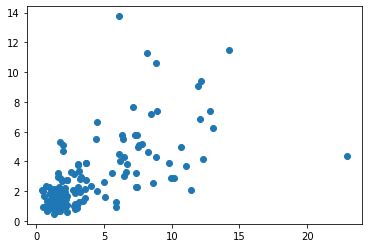

In [62]:
import matplotlib.pyplot as plt
df_station = df_filtered[(df_filtered['skn'] == 1020.1) & (df_filtered['fold'] == 1)]
plt.scatter(df_station['data_in'], yhat_nn)

In [6]:
# x_train, x_test, y_train, y_test = model.train_test_split(df_filtered, fold=1, fine_tune=False)
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
skn = 250
_,_,_,_,x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

new_model = tf.keras.models.load_model('models/testing.hdf5')

def base_model():
    inputs = tf.keras.Input(shape=(100,))
    x = new_model.layers[1](inputs)
    x = new_model.layers[2](x)
    outputs = new_model.layers[3](x)
    _model = tf.keras.Model(inputs, outputs)
    return _model

base_model = base_model()
base_model.trainable = False

inputs = tf.keras.Input(shape=(100,))

x = base_model(inputs, training=False)
x = tf.keras.layers.Dense(units=512, activation='elu')(x)
x = tf.keras.layers.Dense(units=216, activation='elu')(x)
x = tf.keras.layers.Dense(units=64, activation='elu')(x)
outputs = tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.HeNormal, activation='softplus')(x)

complete_model = tf.keras.Model(inputs, outputs)

complete_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=40, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.95, patience=10)
]

2022-07-08 01:35:03.328375: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/apps/software/devel/PCRE/8.41-GCCcore-7.3.0/lib:/opt/apps/software/lang/Perl/5.28.0-GCCcore-7.3.0/lib:/opt/apps/software/tools/expat/2.2.5-GCCcore-7.3.0/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib/python2.7/site-packages/numpy-1.14.5-py2.7-linux-x86_64.egg/numpy/core/lib:/opt/apps/software/lang/Python/2.7.15-foss-2018b/lib:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib64:/opt/apps/software/lib/libffi/3.2.1-GCCcore-7.3.0/lib:/opt/apps/software/math/GMP/6.1.2-GCCcore-7.3.0/lib:/opt/apps/software/devel/SQLite/3.24.0-GCCcore-7.3.0/lib:/opt/apps/software/lang/Tcl/8.6.8-GCCcore-7.3.0/lib:/opt/apps/software/lib/libreadline/7.0-GCCcore-7.3.0/lib:/opt/apps/software/devel/ncurses/6.1-GCCcore-7.3.0/lib:/opt/apps/software/tools/b

In [7]:
history = complete_model.fit(
    x_train_station, y_train_station, epochs=300, batch_size=64,
    verbose=2,
    validation_split = 0.2,
    callbacks=callbacks
)

Epoch 1/300
8/8 - 1s - loss: 8.4149 - root_mean_squared_error: 2.9008 - val_loss: 2.9996 - val_root_mean_squared_error: 1.7319 - lr: 1.0000e-04 - 1s/epoch - 129ms/step
Epoch 2/300
8/8 - 0s - loss: 4.6781 - root_mean_squared_error: 2.1629 - val_loss: 3.4505 - val_root_mean_squared_error: 1.8576 - lr: 1.0000e-04 - 68ms/epoch - 9ms/step
Epoch 3/300
8/8 - 0s - loss: 4.3463 - root_mean_squared_error: 2.0848 - val_loss: 2.5351 - val_root_mean_squared_error: 1.5922 - lr: 1.0000e-04 - 68ms/epoch - 9ms/step
Epoch 4/300
8/8 - 0s - loss: 4.1355 - root_mean_squared_error: 2.0336 - val_loss: 2.4197 - val_root_mean_squared_error: 1.5555 - lr: 1.0000e-04 - 61ms/epoch - 8ms/step
Epoch 5/300
8/8 - 0s - loss: 3.9877 - root_mean_squared_error: 1.9969 - val_loss: 2.4168 - val_root_mean_squared_error: 1.5546 - lr: 1.0000e-04 - 59ms/epoch - 7ms/step
Epoch 6/300
8/8 - 0s - loss: 3.9148 - root_mean_squared_error: 1.9786 - val_loss: 2.4786 - val_root_mean_squared_error: 1.5743 - lr: 1.0000e-04 - 55ms/epoch - 7

In [8]:
epochs = len(history.history['loss'])

In [9]:
# x_train, x_test, y_train, y_test = model.train_test_split(df_filtered, fold=1, fine_tune=False)
skn = 250
_,_,_,_,x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

new_model = tf.keras.models.load_model('models/testing.hdf5')

def base_model():
    inputs = tf.keras.Input(shape=(100,))
    x = new_model.layers[1](inputs)
    x = new_model.layers[2](x)
    
    outputs = new_model.layers[3](x)
    _model = tf.keras.Model(inputs, outputs)
    return _model

base_model = base_model()
base_model.trainable = False

inputs = tf.keras.Input(shape=(100,))

x = base_model(inputs, training=False)
x = tf.keras.layers.Dense(units=512, activation='elu')(x)
x = tf.keras.layers.Dense(units=512, activation='elu')(x)
x = tf.keras.layers.Dense(units=216, activation='elu')(x)
x = tf.keras.layers.Dense(units=64, activation='elu')(x)
outputs = tf.keras.layers.Dense(units=1, kernel_initializer=tf.keras.initializers.HeNormal, activation='softplus')(x)

complete_model = tf.keras.Model(inputs, outputs)

complete_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='mse',
    metrics=[RootMeanSquaredError()]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0, patience=1e3, restore_best_weights=True),
]

history = complete_model.fit(
    x_train_station, y_train_station,
    epochs=epochs,
    batch_size=64,
    verbose=2,
    validation_split=0.0,
    callbacks=callbacks
)

Epoch 1/48
10/10 - 0s - loss: 5.7453 - root_mean_squared_error: 2.3969 - 403ms/epoch - 40ms/step
Epoch 2/48
10/10 - 0s - loss: 4.2569 - root_mean_squared_error: 2.0632 - 73ms/epoch - 7ms/step
Epoch 3/48
10/10 - 0s - loss: 3.7070 - root_mean_squared_error: 1.9254 - 70ms/epoch - 7ms/step
Epoch 4/48
10/10 - 0s - loss: 3.5446 - root_mean_squared_error: 1.8827 - 63ms/epoch - 6ms/step
Epoch 5/48
10/10 - 0s - loss: 3.4709 - root_mean_squared_error: 1.8630 - 65ms/epoch - 6ms/step
Epoch 6/48
10/10 - 0s - loss: 3.5178 - root_mean_squared_error: 1.8756 - 61ms/epoch - 6ms/step
Epoch 7/48
10/10 - 0s - loss: 3.3703 - root_mean_squared_error: 1.8358 - 64ms/epoch - 6ms/step
Epoch 8/48
10/10 - 0s - loss: 3.3900 - root_mean_squared_error: 1.8412 - 63ms/epoch - 6ms/step
Epoch 9/48
10/10 - 0s - loss: 3.3217 - root_mean_squared_error: 1.8225 - 63ms/epoch - 6ms/step
Epoch 10/48
10/10 - 0s - loss: 3.2730 - root_mean_squared_error: 1.8092 - 70ms/epoch - 7ms/step
Epoch 11/48
10/10 - 0s - loss: 3.2067 - root_me

In [10]:
# _,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

yhat_nn = complete_model.predict(x_test_station)
rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
# rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(x_train_station, y_train_station)
yhat_linear_regression = linear_regression.predict(x_test_station)
rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
# rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Fold 1
 LR: 2.1952727620, NN: 2.2767080226


<hr>

In [107]:
df_filtered['skn'].unique()

array([  54. ,   79. ,  250. ,  267. ,  296.1,  311. ,  338. ,  396. ,
        400. ,  406. ,  410. ,  485. ,  703. ,  718. ,  770. ,  783. ,
        784. ,  965. , 1075. , 1117. , 1134. ,   87. ,  702.7, 1020.1])

In [140]:
model = Transfer_Model(inputs=C_GRID, outputs='data_in')
skn = 250
history = model.fine_tune(
    df_filtered, fold=1, skn=skn, retrain_full=True, model_path='models/testing.hdf5',
    epochs=300,
    batch_size=128,
    stopping_patience=100,
    lr=0.00001,
    lr_factor=0.95,
    lr_patience=10,
    verbose=2,
    validation_split=0.3
)

Epoch 1/300
4/4 - 0s - loss: 4.4166 - root_mean_squared_error: 2.1016 - val_loss: 3.5881 - val_root_mean_squared_error: 1.8942 - lr: 1.0000e-05 - 408ms/epoch - 102ms/step
Epoch 2/300
4/4 - 0s - loss: 3.8588 - root_mean_squared_error: 1.9644 - val_loss: 3.5873 - val_root_mean_squared_error: 1.8940 - lr: 1.0000e-05 - 42ms/epoch - 11ms/step
Epoch 3/300
4/4 - 0s - loss: 4.1486 - root_mean_squared_error: 2.0368 - val_loss: 3.5861 - val_root_mean_squared_error: 1.8937 - lr: 1.0000e-05 - 40ms/epoch - 10ms/step
Epoch 4/300
4/4 - 0s - loss: 4.4428 - root_mean_squared_error: 2.1078 - val_loss: 3.5858 - val_root_mean_squared_error: 1.8936 - lr: 1.0000e-05 - 41ms/epoch - 10ms/step
Epoch 5/300
4/4 - 0s - loss: 3.9114 - root_mean_squared_error: 1.9777 - val_loss: 3.5869 - val_root_mean_squared_error: 1.8939 - lr: 1.0000e-05 - 40ms/epoch - 10ms/step
Epoch 6/300
4/4 - 0s - loss: 4.0777 - root_mean_squared_error: 2.0193 - val_loss: 3.5879 - val_root_mean_squared_error: 1.8942 - lr: 1.0000e-05 - 39ms/ep

In [141]:
_,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

yhat_nn = model.model.predict(x_test_station)
rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
# rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

# Linear Regression
linear_regression = LinearRegression()
linear_regression.fit(x_train_station, y_train_station)
yhat_linear_regression = linear_regression.predict(x_test_station)
rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
# rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Fold 1
 LR: 2.1952727620, NN: 2.0850818711


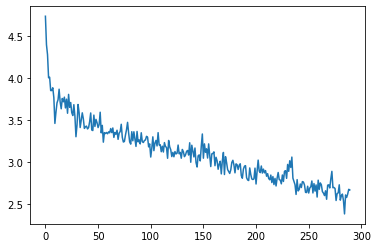

In [133]:
plt.plot(np.arange(len(history.history['loss'])), history.history['loss'])

In [110]:
for skn in df_filtered['skn'].unique():
    model = Transfer_Model(inputs=C_GRID, outputs='data_in')
    model.fine_tune(
        df_filtered, fold=1, skn=skn, retrain_full=True, model_path='models/testing.hdf5',
        epochs=300,
        batch_size=32,
        stopping_patience=50,
        lr=0.0001,
        lr_factor=0.95,
        lr_patience=8,
        verbose=0,
        validation_split=0.3
    )

    _,_,_,_, x_train_station, x_test_station, y_train_station, y_test_station = model.train_test_split(df_filtered, fold=1, fine_tune=True, skn=skn)

    yhat_nn = model.model.predict(x_test_station)
    rmse_nn = mean_squared_error(y_test_station, yhat_nn, squared=False)
    # rmse_nn = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_station), squared=False)

    # Linear Regression
    linear_regression = LinearRegression()
    linear_regression.fit(x_train_station, y_train_station)
    yhat_linear_regression = linear_regression.predict(x_test_station)
    rmse_lr = mean_squared_error(y_test_station, yhat_linear_regression, squared=False)
    # rmse_lr = mean_squared_error(np.power(np.e, Ytest_station), np.power(np.e, yhat_linear_regression), squared=False)

    print('Fold {}\n LR: {:.10f}, NN: {:.10f}'.format(1, rmse_lr, rmse_nn))

Fold 1
 LR: 4.8374567072, NN: 4.4120222939
Fold 1
 LR: 5.0220459358, NN: 5.0389254714


KeyboardInterrupt: 